# Proyecto Redes Neuronales: LSTM (PyTorch)

**Curso:** Redes Neuronales 2025-II  
**Objetivo:** Entrenar y evaluar un modelo LSTM usando PyTorch  
**Autor:** Herney Eduardo Quintero Trochez  
**Fecha:** 2025  
**Universidad:** Universidad Del Valle  

## 0. Configuración de Parámetros Globales

In [ ]:
# Configuracion del experimento
from datetime import datetime as dt
EXPERIMENT_TIMESTAMP = dt.now().strftime("%Y%m%d_%H%M%S")

EXPERIMENT_NAME = "LSTM_PyTorch"
MODEL_TYPE = "LSTM_Torch"
MODEL_SAVE_NAME = f"{MODEL_TYPE}_{EXPERIMENT_TIMESTAMP}"
RANDOM_SEED = 42
PROJECT_PART = "project_part_3"

# Directorios
DATA_DIR = "data"
MODEL_DIR = f"models/{PROJECT_PART}"
OUTPUT_DIR = f"output/{PROJECT_PART}"

# Dataset
TEXT_COLUMN = "review_body"
TITLE_COLUMN = "review_title"
TARGET_COLUMN = "stars"
LANGUAGE_COLUMN = "language"
FILTER_LANGUAGE = "en"
USE_TITLE_AND_BODY = True

# Tokenizacion
MAX_VOCAB_SIZE = 50000
MAX_LENGTH = 200

# Arquitectura del modelo
EMBEDDING_DIM = 256
HIDDEN_SIZE = 256
NUM_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT_RATE = 0.3
RECURRENT_DROPOUT = 0.1

# Entrenamiento
EPOCHS = 30
BATCH_SIZE = 48
LEARNING_RATE = 0.001
PATIENCE = 5
WEIGHT_DECAY = 1e-4
CLIP_GRAD_NORM = 1.0
USE_CLASS_WEIGHTS = True

print(f"=== Configuracion: {EXPERIMENT_NAME} ===")
print(f"Nombre del modelo: {MODEL_SAVE_NAME}")
print(f"Arquitectura: Embedding {EMBEDDING_DIM}d, Hidden {HIDDEN_SIZE}, Layers {NUM_LAYERS}, Bidireccional: {BIDIRECTIONAL}")
print(f"Entrenamiento: LR={LEARNING_RATE}, Batch={BATCH_SIZE}, Patience={PATIENCE}")
print("="*60)

=== Configuracion: LSTM_PyTorch ===
Nombre del modelo: LSTM_Torch_20251130_135830
Arquitectura: Embedding 256d, Hidden 256, Layers 2, Bidireccional: True
Entrenamiento: LR=0.001, Batch=48, Patience=5


## 1. Importación de Librerías

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
from sklearn.metrics import classification_report

# Importar helpers
from helpers.data_loader_torch import DataLoaderTorch
from helpers.model_trainer_torch import ModelTrainerTorch
from helpers.results_manager import ResultsManager
from helpers.visualizer import Visualizer
from helpers.models import LSTMClassifier
from helpers.utils import (
    setup_experiment_environment_torch,
    save_model_components_torch,
    evaluate_model_torch
)

# Configurar ambiente
gpu_info = setup_experiment_environment_torch(RANDOM_SEED)

GPU configurada: 1 GPU(s) disponibles
Usando: NVIDIA GeForce RTX 5070


## 2. Carga y Preprocesamiento de Datos

In [3]:
print("=== Cargando datos ===")

# Inicializar DataLoader
data_loader = DataLoaderTorch(data_dir=DATA_DIR)

# Cargar datasets
train_df, val_df, test_df = data_loader.load_all_data()

print(f"\nTamaños de conjuntos:")
print(f"  Entrenamiento: {len(train_df):,}")
print(f"  Validación: {len(val_df):,}")
print(f"  Prueba: {len(test_df):,}")

# Filtrar por idioma si se especifica
if FILTER_LANGUAGE:
    if LANGUAGE_COLUMN in train_df.columns:
        print(f"\nFiltrando por idioma: {FILTER_LANGUAGE}")
        train_df = train_df[train_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
        val_df = val_df[val_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
        test_df = test_df[test_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
        print(f"Tamaños después de filtrar:")
        print(f"  Entrenamiento: {len(train_df):,}")
        print(f"  Validación: {len(val_df):,}")
        print(f"  Prueba: {len(test_df):,}")

# Verificar distribución de clases
if TARGET_COLUMN in train_df.columns:
    print(f"\nDistribución de clases (entrenamiento):")
    for i in range(1, 6):
        count = len(train_df[train_df[TARGET_COLUMN] == i])
        print(f"  Clase {i} estrellas: {count:,} ({count/len(train_df)*100:.1f}%)")

=== Cargando datos ===
Datos cargados exitosamente: train.csv
Datos cargados exitosamente: validation.csv
Datos cargados exitosamente: test.csv

Tamaños de conjuntos:
  Entrenamiento: 1,200,000
  Validación: 30,000
  Prueba: 30,000

Filtrando por idioma: en
Tamaños después de filtrar:
  Entrenamiento: 200,000
  Validación: 5,000
  Prueba: 5,000

Distribución de clases (entrenamiento):
  Clase 1 estrellas: 40,000 (20.0%)
  Clase 2 estrellas: 40,000 (20.0%)
  Clase 3 estrellas: 40,000 (20.0%)
  Clase 4 estrellas: 40,000 (20.0%)
  Clase 5 estrellas: 40,000 (20.0%)


## 3. Preprocesamiento y Creación de DataLoaders

Esta celda realiza:
- Tokenización de textos
- Construcción de vocabulario
- Conversión a secuencias numéricas
- Padding de secuencias
- Creación de DataLoaders de PyTorch

In [4]:
print("=== Preprocesando datos para embeddings ===")

# Preprocesar datos usando el método de embedding
preprocessing_result = data_loader.preprocess_text_data_embedding(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    text_column=TEXT_COLUMN,
    title_column=TITLE_COLUMN if USE_TITLE_AND_BODY else None,
    target_column=TARGET_COLUMN,
    max_words=MAX_VOCAB_SIZE,
    max_length=MAX_LENGTH,
    use_title_and_body=USE_TITLE_AND_BODY,
    batch_size=BATCH_SIZE
)

# Extraer resultados
train_loader = preprocessing_result['train_loader']
val_loader = preprocessing_result['val_loader']
test_loader = preprocessing_result['test_loader']
num_classes = preprocessing_result['num_classes']
vocab_size = preprocessing_result['vocab_size']
pad_idx = 0  # Keras siempre usa 0 como padding index

print(f"\nVocabulario construido:")
print(f"  Tamaño del vocabulario: {vocab_size:,}")
print(f"  Índice de padding: {pad_idx}")
print(f"  Número de clases: {num_classes}")
print(f"  Max length: {MAX_LENGTH}")

print(f"\nDataLoaders creados:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Ejemplo de un batch
sample_batch = next(iter(train_loader))
print(f"\nEjemplo de batch:")
print(f"  Forma de secuencias: {sample_batch[0].shape}")
print(f"  Forma de labels: {sample_batch[1].shape}")

=== Preprocesando datos para embeddings ===
Preprocesando datos de texto...
Ajustando tokenizer solo con datos de entrenamiento (evitando data leakage)...
Tamaño del vocabulario real: 48282
Vocab size usado (limitado): 48283
Número de clases: 5
Longitud de secuencia: 200
Texto combinado: Sí (título + cuerpo)
Muestras de entrenamiento: 200000
Muestras de validación: 5000
Muestras de prueba: 5000

Vocabulario construido:
  Tamaño del vocabulario: 48,283
  Índice de padding: 0
  Número de clases: 5
  Max length: 200

DataLoaders creados:
  Train batches: 4167
  Val batches: 105
  Test batches: 105

Ejemplo de batch:
  Forma de secuencias: torch.Size([48, 200])
  Forma de labels: torch.Size([48])


## 4. Construcción del Modelo LSTM

In [5]:
print("=== Construyendo modelo LSTM ===")

# Crear modelo
model = LSTMClassifier(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_size=HIDDEN_SIZE,
    num_classes=num_classes,
    num_layers=NUM_LAYERS,
    dropout_rate=DROPOUT_RATE,
    recurrent_dropout=RECURRENT_DROPOUT,
    padding_idx=pad_idx,
    bidirectional=BIDIRECTIONAL
)

print(f"\nArquitectura del modelo:")
print(model)

# Contar parámetros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nParámetros totales: {total_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")

=== Construyendo modelo LSTM ===

Arquitectura del modelo:
LSTMClassifier(
  (embedding): Embedding(48283, 256, padding_idx=0)
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=5, bias=True)
)

Parámetros totales: 14,992,645
Parámetros entrenables: 14,992,645


## 5. Configuración del Entrenamiento

In [6]:
print("=== Configurando entrenamiento ===")

# Calcular class weights para manejar desbalanceo
y_train_np = preprocessing_result['y_train'].numpy()
class_counts = np.bincount(y_train_np)
total_samples = len(y_train_np)
class_weights = total_samples / (len(class_counts) * class_counts)
class_weights_tensor = torch.FloatTensor(class_weights) if USE_CLASS_WEIGHTS else None

print(f"Distribucion de clases:")
for i, count in enumerate(class_counts):
    weight_str = f"weight: {class_weights[i]:.4f}" if USE_CLASS_WEIGHTS else "weight: 1.0"
    print(f"  Clase {i+1}: {count:,} muestras, {weight_str}")

# Funcion de perdida
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss(
    weight=class_weights_tensor.to(device) if class_weights_tensor is not None else None
)

# Optimizador
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

print(f"\nOptimizador: Adam (lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})")
print(f"Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)")

=== Configurando entrenamiento ===
Distribucion de clases:
  Clase 1: 40,000 muestras, weight: 1.0000
  Clase 2: 40,000 muestras, weight: 1.0000
  Clase 3: 40,000 muestras, weight: 1.0000
  Clase 4: 40,000 muestras, weight: 1.0000
  Clase 5: 40,000 muestras, weight: 1.0000

Optimizador: Adam (lr=0.001, weight_decay=0.0001)
Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)


## 6. Entrenamiento del Modelo

In [7]:
print("=== Iniciando entrenamiento ===")

# Inicializar trainer
trainer = ModelTrainerTorch(model_dir=MODEL_DIR)

# Entrenar modelo con nombre unico
training_results = trainer.train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=EPOCHS,
    patience=PATIENCE,
    model_name=MODEL_SAVE_NAME,
    scheduler=scheduler,
    clip_grad_norm=CLIP_GRAD_NORM,
    verbose=True
)

print(f"\n=== Entrenamiento completado ===")
print(f"Épocas entrenadas: {training_results['epochs_trained']}")
print(f"Tiempo total: {training_results['training_time']:.2f}s")
print(f"Mejor Val Loss: {training_results['best_val_loss']:.4f}")
print(f"Mejor Val Accuracy: {training_results['best_val_accuracy']:.4f}")

=== Iniciando entrenamiento ===
Usando dispositivo: cuda

Entrenando LSTM_Torch_20251130_135830...
Parámetros totales: 14,992,645
Parámetros entrenables: 14,992,645
Gradient clipping activado: max_norm=1.0


Epoch 1/30 [Val]: 100%|██████████| 105/105 [00:00<00:00, 152.56it/s, loss=0.5378, acc=58.38%]



Epoch 1/30:
  Train Loss: 0.9998, Train Acc: 0.5628, Train F1-Macro: 0.5589
  Val Loss: 0.9437, Val Acc: 0.5838, Val F1-Macro: 0.5767
  Learning Rate: 0.001000
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5767)


Epoch 2/30 [Val]: 100%|██████████| 105/105 [00:00<00:00, 153.97it/s, loss=0.4697, acc=59.54%]



Epoch 2/30:
  Train Loss: 0.9224, Train Acc: 0.5999, Train F1-Macro: 0.5973
  Val Loss: 0.9172, Val Acc: 0.5954, Val F1-Macro: 0.5939
  Learning Rate: 0.001000
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5939)


Epoch 3/30 [Val]: 100%|██████████| 105/105 [00:00<00:00, 149.49it/s, loss=0.2226, acc=59.44%]



Epoch 3/30:
  Train Loss: 0.8988, Train Acc: 0.6086, Train F1-Macro: 0.6063
  Val Loss: 0.9341, Val Acc: 0.5944, Val F1-Macro: 0.5869
  Learning Rate: 0.001000
  Épocas sin mejora: 1/5


Epoch 4/30 [Val]: 100%|██████████| 105/105 [00:00<00:00, 156.84it/s, loss=0.4769, acc=59.86%]



Epoch 4/30:
  Train Loss: 0.8855, Train Acc: 0.6167, Train F1-Macro: 0.6145
  Val Loss: 0.9082, Val Acc: 0.5986, Val F1-Macro: 0.5998
  Learning Rate: 0.001000
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5998)


Epoch 5/30 [Val]: 100%|██████████| 105/105 [00:00<00:00, 154.41it/s, loss=0.4951, acc=60.24%]



Epoch 5/30:
  Train Loss: 0.8757, Train Acc: 0.6202, Train F1-Macro: 0.6181
  Val Loss: 0.9106, Val Acc: 0.6024, Val F1-Macro: 0.5947
  Learning Rate: 0.001000
  Épocas sin mejora: 1/5


Epoch 6/30 [Val]: 100%|██████████| 105/105 [00:00<00:00, 151.94it/s, loss=0.7882, acc=60.08%]



Epoch 6/30:
  Train Loss: 0.8698, Train Acc: 0.6239, Train F1-Macro: 0.6217
  Val Loss: 0.9034, Val Acc: 0.6008, Val F1-Macro: 0.5933
  Learning Rate: 0.001000
  Épocas sin mejora: 2/5


Epoch 7/30 [Val]: 100%|██████████| 105/105 [00:00<00:00, 153.36it/s, loss=0.5262, acc=60.70%]



Epoch 7/30:
  Train Loss: 0.8646, Train Acc: 0.6258, Train F1-Macro: 0.6238
  Val Loss: 0.8950, Val Acc: 0.6070, Val F1-Macro: 0.6066
  Learning Rate: 0.001000
  ✓ Mejor modelo guardado (Val F1-Macro: 0.6066)


Epoch 8/30 [Val]: 100%|██████████| 105/105 [00:00<00:00, 152.04it/s, loss=0.2097, acc=61.12%]



Epoch 8/30:
  Train Loss: 0.8600, Train Acc: 0.6280, Train F1-Macro: 0.6260
  Val Loss: 0.8976, Val Acc: 0.6112, Val F1-Macro: 0.6027
  Learning Rate: 0.001000
  Épocas sin mejora: 1/5


Epoch 9/30 [Val]: 100%|██████████| 105/105 [00:00<00:00, 155.26it/s, loss=0.3334, acc=60.82%]



Epoch 9/30:
  Train Loss: 0.8560, Train Acc: 0.6301, Train F1-Macro: 0.6281
  Val Loss: 0.8895, Val Acc: 0.6082, Val F1-Macro: 0.6063
  Learning Rate: 0.001000
  Épocas sin mejora: 2/5


Epoch 10/30 [Val]: 100%|██████████| 105/105 [00:00<00:00, 156.53it/s, loss=0.3426, acc=60.24%]



Epoch 10/30:
  Train Loss: 0.8546, Train Acc: 0.6302, Train F1-Macro: 0.6282
  Val Loss: 0.9000, Val Acc: 0.6024, Val F1-Macro: 0.5995
  Learning Rate: 0.001000
  Épocas sin mejora: 3/5


Epoch 11/30 [Val]: 100%|██████████| 105/105 [00:00<00:00, 159.88it/s, loss=0.1944, acc=60.16%]



Epoch 11/30:
  Train Loss: 0.8519, Train Acc: 0.6317, Train F1-Macro: 0.6297
  Val Loss: 0.8981, Val Acc: 0.6016, Val F1-Macro: 0.5941
  Learning Rate: 0.001000
  Épocas sin mejora: 4/5


Epoch 12/30 [Val]: 100%|██████████| 105/105 [00:00<00:00, 149.69it/s, loss=0.3925, acc=60.84%]



Epoch 12/30:
  Train Loss: 0.8495, Train Acc: 0.6331, Train F1-Macro: 0.6309
  Val Loss: 0.8943, Val Acc: 0.6084, Val F1-Macro: 0.6103
  Learning Rate: 0.000500
  ✓ Mejor modelo guardado (Val F1-Macro: 0.6103)


Epoch 13/30 [Val]: 100%|██████████| 105/105 [00:00<00:00, 158.04it/s, loss=0.2415, acc=61.60%]



Epoch 13/30:
  Train Loss: 0.8218, Train Acc: 0.6464, Train F1-Macro: 0.6446
  Val Loss: 0.8810, Val Acc: 0.6160, Val F1-Macro: 0.6104
  Learning Rate: 0.000500
  ✓ Mejor modelo guardado (Val F1-Macro: 0.6104)


Epoch 14/30 [Val]: 100%|██████████| 105/105 [00:00<00:00, 153.87it/s, loss=0.3012, acc=61.60%]



Epoch 14/30:
  Train Loss: 0.8183, Train Acc: 0.6483, Train F1-Macro: 0.6468
  Val Loss: 0.8809, Val Acc: 0.6160, Val F1-Macro: 0.6161
  Learning Rate: 0.000500
  ✓ Mejor modelo guardado (Val F1-Macro: 0.6161)


Epoch 15/30 [Val]: 100%|██████████| 105/105 [00:00<00:00, 153.46it/s, loss=0.2035, acc=61.12%]



Epoch 15/30:
  Train Loss: 0.8188, Train Acc: 0.6477, Train F1-Macro: 0.6459
  Val Loss: 0.8940, Val Acc: 0.6112, Val F1-Macro: 0.6046
  Learning Rate: 0.000500
  Épocas sin mejora: 1/5


Epoch 16/30 [Val]: 100%|██████████| 105/105 [00:00<00:00, 151.15it/s, loss=0.2552, acc=61.26%]



Epoch 16/30:
  Train Loss: 0.8205, Train Acc: 0.6471, Train F1-Macro: 0.6453
  Val Loss: 0.8841, Val Acc: 0.6126, Val F1-Macro: 0.6107
  Learning Rate: 0.000500
  Épocas sin mejora: 2/5


Epoch 17/30 [Val]: 100%|██████████| 105/105 [00:00<00:00, 160.11it/s, loss=0.2765, acc=61.26%]



Epoch 17/30:
  Train Loss: 0.8218, Train Acc: 0.6472, Train F1-Macro: 0.6453
  Val Loss: 0.8809, Val Acc: 0.6126, Val F1-Macro: 0.6096
  Learning Rate: 0.000250
  Épocas sin mejora: 3/5


Epoch 18/30 [Val]: 100%|██████████| 105/105 [00:00<00:00, 158.28it/s, loss=0.2140, acc=61.60%]



Epoch 18/30:
  Train Loss: 0.8000, Train Acc: 0.6581, Train F1-Macro: 0.6566
  Val Loss: 0.8844, Val Acc: 0.6160, Val F1-Macro: 0.6111
  Learning Rate: 0.000250
  Épocas sin mejora: 4/5


Epoch 19/30 [Val]: 100%|██████████| 105/105 [00:00<00:00, 154.24it/s, loss=0.3555, acc=61.46%]



Epoch 19/30:
  Train Loss: 0.7977, Train Acc: 0.6597, Train F1-Macro: 0.6582
  Val Loss: 0.8885, Val Acc: 0.6146, Val F1-Macro: 0.6163
  Learning Rate: 0.000250
  ✓ Mejor modelo guardado (Val F1-Macro: 0.6163)


Epoch 20/30 [Val]: 100%|██████████| 105/105 [00:00<00:00, 155.50it/s, loss=0.2858, acc=61.52%]



Epoch 20/30:
  Train Loss: 0.7986, Train Acc: 0.6589, Train F1-Macro: 0.6573
  Val Loss: 0.8805, Val Acc: 0.6152, Val F1-Macro: 0.6125
  Learning Rate: 0.000250
  Épocas sin mejora: 1/5


Epoch 21/30 [Val]: 100%|██████████| 105/105 [00:00<00:00, 159.62it/s, loss=0.2440, acc=60.60%]



Epoch 21/30:
  Train Loss: 0.7998, Train Acc: 0.6581, Train F1-Macro: 0.6566
  Val Loss: 0.8892, Val Acc: 0.6060, Val F1-Macro: 0.6035
  Learning Rate: 0.000250
  Épocas sin mejora: 2/5


Epoch 22/30 [Val]: 100%|██████████| 105/105 [00:00<00:00, 153.31it/s, loss=0.3399, acc=61.30%]



Epoch 22/30:
  Train Loss: 0.8018, Train Acc: 0.6577, Train F1-Macro: 0.6562
  Val Loss: 0.8883, Val Acc: 0.6130, Val F1-Macro: 0.6122
  Learning Rate: 0.000250
  Épocas sin mejora: 3/5


Epoch 23/30 [Val]: 100%|██████████| 105/105 [00:00<00:00, 154.21it/s, loss=0.2572, acc=60.94%]



Epoch 23/30:
  Train Loss: 0.8042, Train Acc: 0.6574, Train F1-Macro: 0.6558
  Val Loss: 0.8889, Val Acc: 0.6094, Val F1-Macro: 0.6066
  Learning Rate: 0.000125
  Épocas sin mejora: 4/5


Epoch 24/30 [Val]: 100%|██████████| 105/105 [00:00<00:00, 154.60it/s, loss=0.3112, acc=60.68%]



Epoch 24/30:
  Train Loss: 0.7853, Train Acc: 0.6671, Train F1-Macro: 0.6658
  Val Loss: 0.8955, Val Acc: 0.6068, Val F1-Macro: 0.6064
  Learning Rate: 0.000125
  Épocas sin mejora: 5/5

Early stopping en época 24

Mejor modelo restaurado
Modelo guardado en: models/project_part_3/LSTM_Torch_20251130_135830.pth

=== Entrenamiento completado ===
Épocas entrenadas: 24
Tiempo total: 1837.02s
Mejor Val Loss: 0.8885
Mejor Val Accuracy: 0.6146


## 7. Evaluación en Conjunto de Prueba

In [8]:
print("=== Evaluando en conjunto de prueba ===")

# Evaluar modelo
test_results = trainer.evaluate_model(
    model=model,
    test_loader=test_loader,
    criterion=criterion
)

print(f"\n=== Resultados en Test ===")
print(f"Test Loss: {test_results['test_loss']:.4f}")
print(f"Test Accuracy: {test_results['test_accuracy']:.4f}")

# Reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(
    test_results['labels'],
    test_results['predictions'],
    target_names=[f"{i+1} estrellas" for i in range(num_classes)],
    digits=4
))

=== Evaluando en conjunto de prueba ===

Evaluando modelo en conjunto de prueba...


Evaluando: 100%|██████████| 105/105 [00:00<00:00, 171.74it/s]


Test Loss: 0.9047
Test Accuracy: 0.6154
Test F1-Macro: 0.6149

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.69      0.69      1000
           1       0.52      0.52      0.52      1000
           2       0.51      0.49      0.50      1000
           3       0.59      0.62      0.60      1000
           4       0.75      0.77      0.76      1000

    accuracy                           0.62      5000
   macro avg       0.61      0.62      0.61      5000
weighted avg       0.61      0.62      0.61      5000


=== Resultados en Test ===
Test Loss: 0.9047
Test Accuracy: 0.6154

Reporte de clasificación:
              precision    recall  f1-score   support

 1 estrellas     0.6990    0.6850    0.6919      1000
 2 estrellas     0.5183    0.5230    0.5207      1000
 3 estrellas     0.5105    0.4880    0.4990      1000
 4 estrellas     0.5934    0.6160    0.6045      1000
 5 estrellas     0.7522    0.7650    0.7586      1000

    

## 8. Visualización de Resultados

=== Generando visualizaciones ===
Gráfico de historial de entrenamiento guardado en: output/project_part_3/LSTM_Torch_history.png


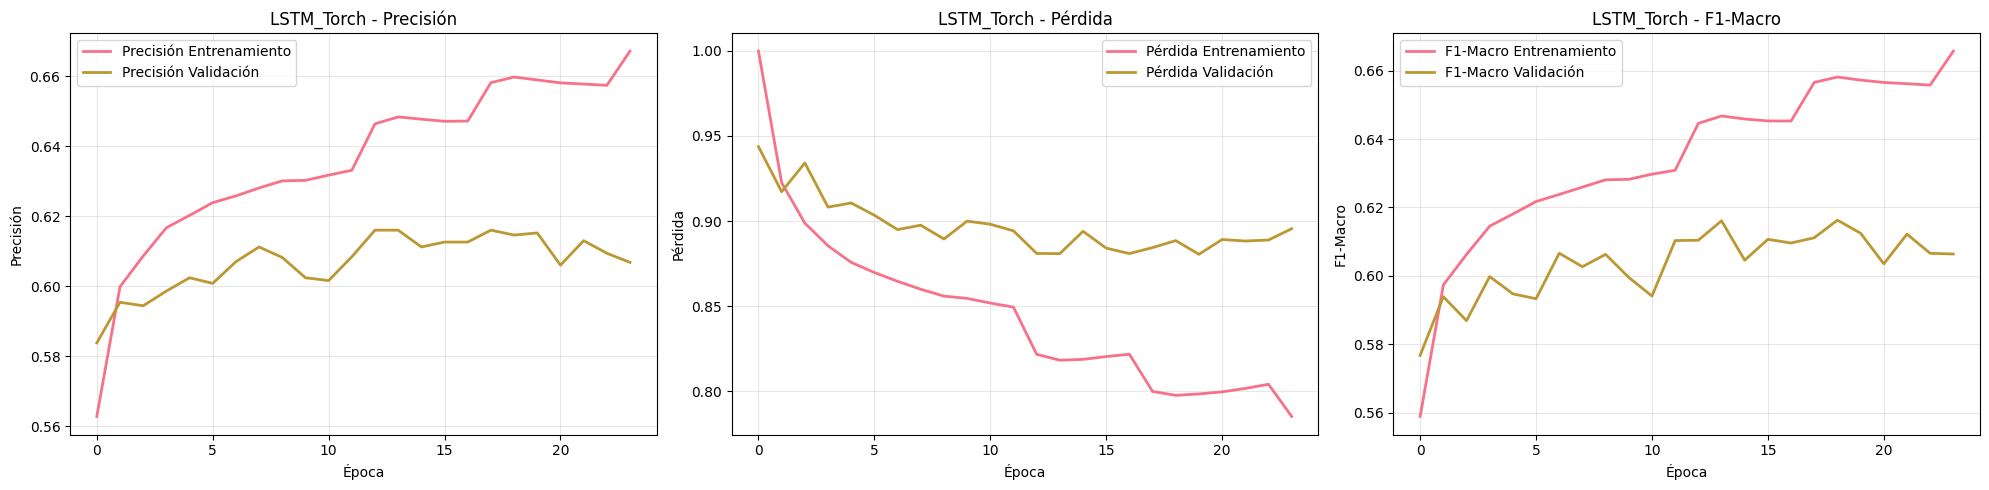

Matriz de confusión guardada en: output/project_part_3/LSTM_Torch_confusion_matrix.png


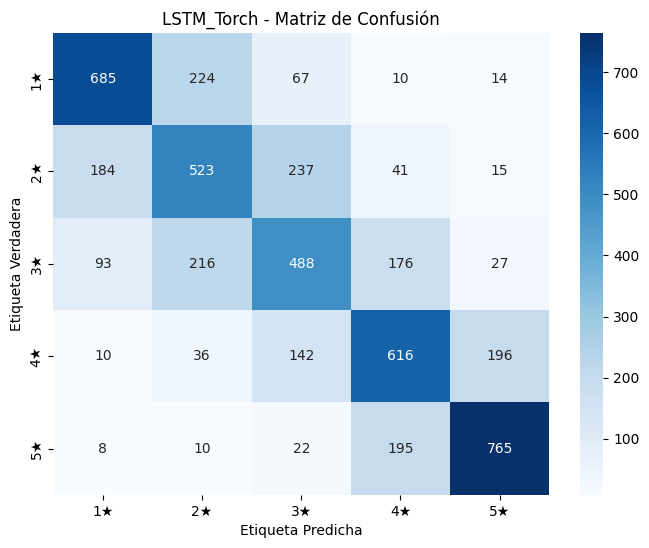

Visualizaciones guardadas en: output/project_part_3


In [9]:
print("=== Generando visualizaciones ===")

# Historia de entrenamiento
history = training_results['history']

# Graficar historia de entrenamiento (pérdida y accuracy)
Visualizer.plot_training_history(
    history=history,
    model_name=MODEL_TYPE,
    save_path=os.path.join(OUTPUT_DIR, f'{MODEL_TYPE}_history.png'),
    framework='pytorch'
)

# Matriz de confusión
Visualizer.plot_confusion_matrix(
    y_true=test_results['labels'],
    y_pred=test_results['predictions'],
    class_names=[f"{i+1}★" for i in range(num_classes)],
    model_name=MODEL_TYPE,
    save_path=os.path.join(OUTPUT_DIR, f'{MODEL_TYPE}_confusion_matrix.png')
)

print("Visualizaciones guardadas en:", OUTPUT_DIR)

## 9. Guardado de Resultados del Experimento

In [10]:
print("=== Guardando resultados del experimento ===")

# Reporte de clasificacion
from sklearn.metrics import classification_report as sklearn_classification_report
classification_rep = sklearn_classification_report(
    test_results['labels'],
    test_results['predictions'],
    target_names=[f"{i+1}★" for i in range(num_classes)],
    output_dict=True
)

# Guardar componentes con nombre unico (tokenizer, label_encoder, etc)
save_model_components_torch(
    model_name=MODEL_SAVE_NAME,
    model=model,
    tokenizer=data_loader.tokenizer,
    label_encoder=data_loader.label_encoder,
    max_length=MAX_LENGTH,
    model_dir=MODEL_DIR
)

# Corregir model_path en training_results para que coincida con el nombre guardado
training_results['model_path'] = f"{MODEL_DIR}/{MODEL_SAVE_NAME}.pth"

# Preparar datos del experimento
experiment_data = {
    'experiment_name': f"{EXPERIMENT_NAME}_{EXPERIMENT_TIMESTAMP}",
    'configuration': {
        'model_type': MODEL_TYPE,
        'model_save_name': MODEL_SAVE_NAME,
        'framework': 'pytorch',
        'language_filter': FILTER_LANGUAGE,
        'max_vocab_size': MAX_VOCAB_SIZE,
        'max_length': MAX_LENGTH,
        'embedding_dim': EMBEDDING_DIM,
        'hidden_size': HIDDEN_SIZE,
        'num_layers': NUM_LAYERS,
        'bidirectional': BIDIRECTIONAL,
        'dropout_rate': DROPOUT_RATE,
        'recurrent_dropout': RECURRENT_DROPOUT,
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'weight_decay': WEIGHT_DECAY,
        'clip_grad_norm': CLIP_GRAD_NORM,
        'patience': PATIENCE,
        'total_parameters': total_params,
        'gpu_used': gpu_info['gpu_available']
    },
    'dataset_info': {
        'train_samples': len(train_loader.dataset),
        'val_samples': len(val_loader.dataset),
        'test_samples': len(test_loader.dataset),
        'num_classes': num_classes,
        'vocab_size': vocab_size,
        'use_title_and_body': USE_TITLE_AND_BODY
    },
    'training_results': training_results,
    'evaluation_metrics': {
        'test_accuracy': test_results['test_accuracy'],
        'test_loss': test_results['test_loss'],
        'f1_macro': classification_rep['macro avg']['f1-score'],
        'f1_weighted': classification_rep['weighted avg']['f1-score'],
        'classification_report': classification_rep
    },
    'gpu_info': gpu_info
}

# Guardar experimento
results_mgr = ResultsManager(output_dir="output", project_part=PROJECT_PART)
experiment_id = results_mgr.save_experiment_results(experiment_data)

print(f"\nExperimento #{experiment_id} guardado")
print(f"Modelo guardado en: {MODEL_DIR}/{MODEL_SAVE_NAME}.pth")

=== Guardando resultados del experimento ===
Modelo guardado: models/project_part_3/LSTM_Torch_20251130_135830.pth
  - Configuración guardada: {'vocab_size': 48283, 'embedding_dim': 256, 'hidden_size': 256, 'num_classes': 5, 'num_layers': 2, 'bidirectional': True, 'max_length': 200}
Tokenizer guardado: models/project_part_3/LSTM_Torch_20251130_135830_tokenizer.pkl
Label encoder guardado: models/project_part_3/LSTM_Torch_20251130_135830_label_encoder.pkl
Componentes guardados en models/project_part_3/
Experiment 5 (LSTM_PyTorch_20251130_135830) saved to output/project_part_3/experiment_history.json

Experimento #5 guardado
Modelo guardado en: models/project_part_3/LSTM_Torch_20251130_135830.pth
